
# 基于 pyqcat-monster 的单比特门表征流程

在本教程中，我们将演示如何使用 pyqcat-monster 进行单比特表征流程测试。在这里你可以了解到：

- 基于 monster 的单比特表征流程测试；
- 基于 montser 的相关 API 使用方式；

在此基础上，我们还提供了 [monster]() 的 API 文档，期待您的阅读。当您发现有错误或者需要优化的地方，欢迎您通过 [pyqcat社区](https://document.qpanda.cn/space/9030MdOBwNfe5oqw) 向我们反馈，您的意见是我们不断进步的动力！

## 创建实验环境

- 若您未安装 pyqcat 包（monster），通过本地源码测试，需要执行下面操作，将 monster 项目环境加载到 jupyter 中；
- 若安装了 pyqcat 包（monster），跳过此步骤

In [1]:
# import sys

# package_root = "../../pyqcat-monster"
# sys.path.insert(0, package_root)

### 导入依赖包

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyQCat.qubit import Qubit
from pyQCat.tools import qarange
from pyQCat.context import ExperimentContext
from pyQCat.invoker import Invoker
from pyQCat.parameters import get_parameters
from pyQCat.types import Quality
from pyQCat.log import pyqlog
from pyQCat.experiments import *

%matplotlib notebook
pd.set_option('max_colwidth', None)

### 用户信息配置

In [2]:
conf_file = r'F:\MonsterTest_QT8013\conf\config.conf'

username = "wangpeng"
password = "8013"


# Invoker.verify_account(username=username, password=password)
Invoker.load_account()

{'code': 200,
 'data': {'username': 'wangpeng',
  'groups': 'normal',
  'email': 'pwang0110@mail.ustc.edu.cn',
  'phone_num': None,
  'is_super': False,
  'is_admin': False,
  'status': 0,
  'create_time': '2022-11-11 16:58:11',
  'last_login_time': '2022-12-09 11:43:34',
  'id': '636e0ea3eac949e7d31db591'},
 'msg': 'success'}

### 检索系统配置信息

In [65]:
pd.DataFrame(context.config_table())

,parameter,module,value
0,sample,system,220826-72bit-300pin-V8.2-Base-24#_monster
1,env_name,system,D1_env(QT8013)
2,point_label,system,q70_+0.035V
3,invoker_addr,system,tcp://192.168.110.211:8088
4,baseband_freq,system,566.667
5,qaio_type,system,30
6,save_type,system,local
7,local_root,system,E:\Data\D1\20221107
8,log_path,system,E:\Data\D121107
9,config_path,system,F:\MonsterTest_QT8013\conf


### 实验参数配置

In [14]:
def single_qubit_cali_context(
    qubit_name: str,
    env_bit: list,
    use_dcm: bool = False,
    ac_switch: bool = True
):
    """ 应用场景：
        - 单比特表征所有流程
    """
    context = ExperimentContext(conf_file)
    context.configure_inst()
    

    new_env_bit = []
    for bit in env_bit:
        base_bit = context.get_base_qubit(bit)
        if base_bit.name == qubit_name:
            base_bit.ac = base_bit.dc_max - 0.028
        elif isinstance(base_bit, Qubit):
            base_bit.ac = base_bit.dc_min
        else:
            base_bit.ac = base_bit.dc_max
        base_bit.save_data()
        new_env_bit.append(base_bit)
        
    context.configure_qubits(qubit_name)

    if ac_switch:
        context.maximize_compensate()
    else:
        context.minimize_compensate()
    context.configure_environment(new_env_bit)
    context.configure_crosstalk_dict()

    if use_dcm:
        context.configure_dcm(qubit_name)

    return context

In [15]:
q_name = "q71"
ENV_BIT = ["q64", "q65", "q69", "q70", "q71", "q72", "c6470", "c6571", "c6970", "c7071", "c7172"]

context = single_qubit_cali_context(q_name, ENV_BIT, use_dcm=False, ac_switch=True)
qubit = context.qubit

2022-12-11 17:13:28 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |              q71_+0.028V               |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|

2022-12-11 17:13:28 |  UPDATE  | Save q64 to data service success.
2022-12-11 17:13:28 |  UPDATE  | Save q65 to data service success.
2022-12-11 17:13:28 |  UPDATE  | Save q69 to data service success.
2022-12-11 17:13:28 |  UPDATE  | Save q70 to data service success.
2022-12-11 17:13:28 |  UPDATE  | Save q71 to data service success.
2022-12-11 17:13:28 |  UPDATE  | Save q72 to data ser

In [17]:
qubit.ac

-0.085

In [6]:

qubit.z_dc_channel = 21
qubit.dc = -0.278
qubit.save_data()

2022-12-01 21:11:30 |  UPDATE  | Save q71 to data service success.


In [8]:
# with open("E:/Data/D1/20221107/work_pint.json","r") as f:
#     work_pint = json.load(f)
# print(work_pint)
# for bit in ENV_BIT:
#     if bit[0] is 'q':
#         q = get_parameters('qubit',bit)
#         q.dc_max = work_pint[bit][0]
#         q.dc_min = work_pint[bit][1]
#         q.save_data()
#     elif bit[0] is 'c':
#         q = get_parameters('coupler',bit)
#         q.dc_max = work_pint[bit][0]
#         q.dc_min = work_pint[bit][1]
#         q.save_data()

{'q69': [-0.026, 0.117], 'q70': [-0.063, 0.082], 'q71': [-0.057, 0.095], 'q72': [-0.03, 0.109], 'q64': [-0.056, 0.094], 'q65': [-0.063, 0.083], 'c6470': [-0.133, 0.092], 'c6571': [-0.125, 0.0], 'c6970': [0.089, -0.08], 'c7071': [0.108, -0.045], 'c7172': [0.087, -0.058]}
2022-12-10 21:42:35 |  UPDATE  | Save q64 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save q65 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save q69 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save q70 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save q71 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save q72 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save c6470 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save c6571 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save c6970 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save c7071 to data service success.
2022-12-10 21:42:35 |  UPDATE  | Save c7172 to data

In [14]:
get_parameters('qubit','q70').dc_max

-0.063

### 检索实验环境配置参数

In [7]:
pd.DataFrame(context.context_table())

,parameter,object,count
0,config,F:\MonsterTest_QT8013\conf\config.conf,
1,qubits,[Qubit(bit=70)],1
2,couplers,[],0
3,discriminators,None,0
4,compensates,"{Qubit(bit=64): PulseCorrectionQ64, Qubit(bit=65): PulseCorrectionQ65, Qubit(bit=69): PulseCorrectionQ69, Qubit(bit=71): PulseCorrectionQ71, Qubit(bit=72): PulseCorrectionQ72, Coupler(bit=6470, driveQ64, probeQ70): PulseCorrectionC6470, Coupler(bit=6571, driveQ65, probeQ71): PulseCorrectionC6571, Coupler(bit=6970, driveQ69, probeQ70): PulseCorrectionC6970, Coupler(bit=7071, driveQ70, probeQ71): PulseCorrectionC7071, Coupler(bit=7172, driveQ71, probeQ72): PulseCorrectionC7172, Qubit(bit=70): PulseCorrectionQ70}",11
5,working_dc,True,
6,crosstalk_dict,True,


### 检索初始比特参数信息

In [145]:
pd.DataFrame(context.base_qubit_table(context.qubit))

,parameter,value,unit,update_time
0,tunable,True,-,None
1,goodness,False,-,None
2,drive_freq,4035.221,MHz,None
3,drive_power,-20,db,None
4,probe_freq,7002.535,MHz,None
5,probe_power,-34,db,None
6,tls_freq,None,MHz,None
7,anharmonicity,-240,db,None
8,dc,-0.278,v,None
9,dc_max,-0.057,v,None


### 检索 DC 配置信息

In [12]:
pd.DataFrame(context.work_dc_table())

,qubit,z_dc_channel,value
0,Coupler(bit=7172),9,0.0v
1,Qubit(bit=71),21,-0.278v


In [18]:
pd.DataFrame(context.work_ac_table())

,qubit,z_flux_channel,value,m_pulse_model,m_pulse_params,compensate
0,Qubit(bit=64),14,0.094v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ64
1,Qubit(bit=65),9,0.083v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ65
2,Qubit(bit=69),22,0.117v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ69
3,Qubit(bit=70),21,0.082v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ70
4,Qubit(bit=71),18,-0.085v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ71
5,Qubit(bit=72),13,0.109v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ72
6,"Coupler(bit=6470, driveQ64, probeQ70)",23,-0.133v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6470
7,"Coupler(bit=6571, driveQ65, probeQ71)",16,-0.125v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6571
8,"Coupler(bit=6970, driveQ69, probeQ70)",24,0.089v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6970
9,"Coupler(bit=7071, driveQ70, probeQ71)",19,0.108v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC7071


### 检索线路补偿器信息

In [77]:
qubit.z_dc_channel = 21
qubit.dc = -0.274
qubit.save_data()

2022-11-22 21:41:57 |  UPDATE  | Save q70 to data service success.


In [25]:
pd.DataFrame(context.compensates_table())

,name,x_delay,z_delay,z_compensate,distortion_width,distortion_data_len,distortion_ab,distortion_type
0,q64,0.0,0.0,0.0,0,0,[],width
1,q65,0.0,0.0,0.0,0,0,[],width
2,q69,0.0,0.0,0.0,0,0,[],width
3,q71,0.0,0.0,0.0,0,0,[],width
4,q72,0.0,0.0,0.0,0,0,[],width
5,c6470,0.0,0.0,0.0,0,0,[],width
6,c6571,0.0,0.0,0.0,0,0,[],width
7,c6970,0.0,0.0,0.0,0,0,[],width
8,c7071,0.0,0.0,0.0,0,0,[],width
9,c7172,0.0,0.0,0.0,0,0,[],width


## CavitySpecturm

Tunbale实验用于获取比特腔调制谱，简并点电压及读取频率

### 驱动线不加波形的能谱粗测

2022-12-11 17:14:10 |   EXP    | CavityFreqSpectrum register success, id 63959f62d87a606edd99d4fc
2022-12-11 17:14:10 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\CavityFreqSpectrum\q71\2022-12-11\17.14.10\


<IPython.core.display.Javascript object>


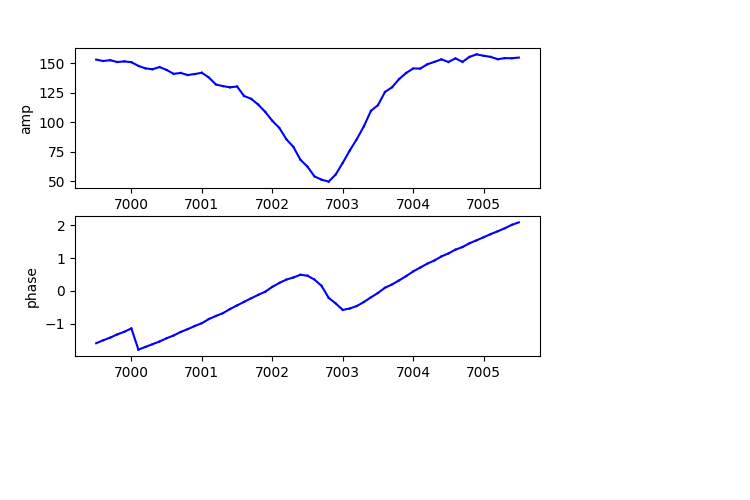

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-11 17:14:59 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7002.749 | MHz  | R²=0.9975(perfect) | 


In [19]:
cs_exp = CavityFreqSpectrum.from_experiment_context(context)

cs_exp.set_experiment_options(
    ac_prepare_time=8000,
    add_pi_pulse=False,
#     simulator_data_path='../scripts/simulator/data/CavityFreqSpectrum/',
    readout_power=-40,
)

cs_exp.set_analysis_options(
    is_plot=True,
    quality_bounds=[0.98, 0.95, 0.85]
)

cs_exp.run()

### 查看实验结果

In [28]:
pd.DataFrame(cs_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fc,7126.654,MHz,{},R²=0.9988(perfect)


### 查看实验结果图

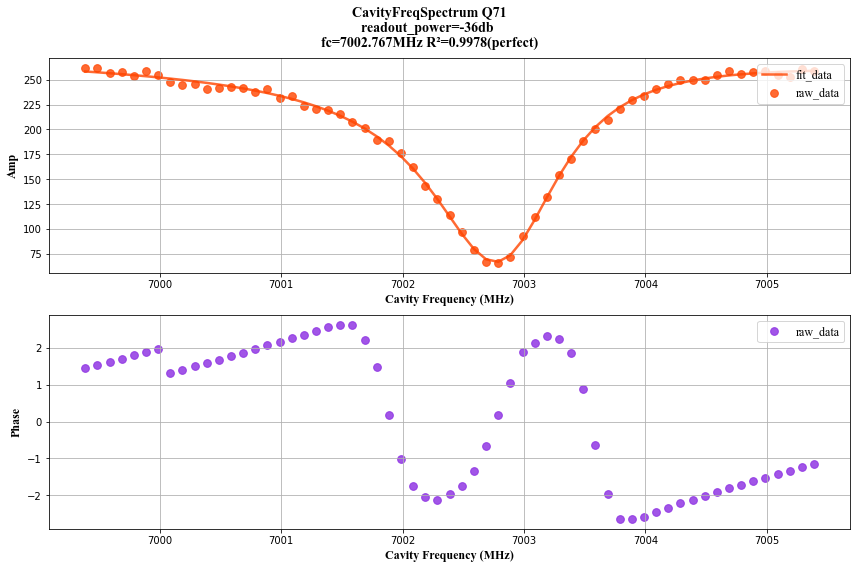

In [21]:
cs_exp.analysis.drawer.figure

### 判断结果质量并更新数据库

In [20]:
if cs_exp.analysis.quality.descriptor in [Quality.perfect, Quality.normal]:
    qubit.probe_freq = cs_exp.analysis.results.fr.value
    qubit.probe_power = cs_exp.experiment_options.readout_power
    pyqlog.info(f'Update {qubit} probe_freq {qubit.probe_freq}MHz, probe_power {qubit.probe_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-11 17:15:24 |   INFO   | Update Qubit(bit=71) probe_freq 7002.749MHz, probe_power -40db
2022-12-11 17:15:24 |  UPDATE  | Save q71 to data service success.


### 查询比特参数信息，检查是否更新成功

In [12]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7126.256,MHz,None
1,probe_power,-36.000,db,None


In [166]:
qubit.xy_channel
# qubit.save_data()

21

## QubitSpecturm

### 大范围能谱粗扫实验

2022-11-23 22:10:27 |   EXP    | QubitSpectrum register success, id 637e29d3a8141d908a35d067
2022-11-23 22:10:27 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitSpectrum\q70\2022-11-23\22.10.27\


<IPython.core.display.Javascript object>


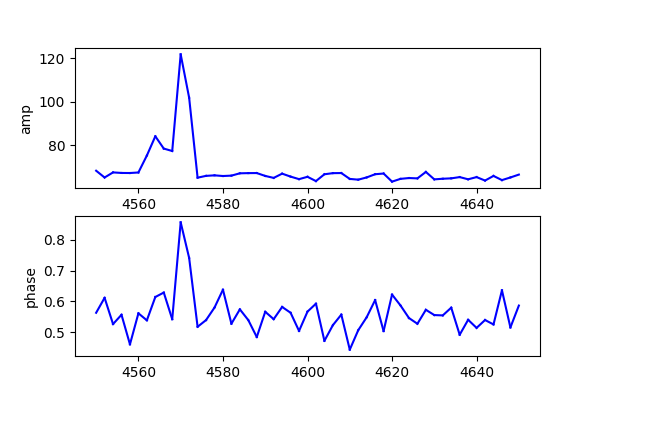

  0%|          | 0/51 [00:00<?, ?it/s]

2022-11-23 22:11:02 |  RESULT  | Experiment results as follow:
| name  | describe |  value   | unit |      quality       | 
-----------------------------------------------------------
| peaks |  peaks   | [4570.5] | MHz  | SNR=4.215(perfect) | 


In [110]:
qs_exp = QubitSpectrum.from_experiment_context(context)

qs_exp.set_experiment_options(
    freq_list=qarange(4550, 4650, 2),
    drive_power=-40,
    z_amp=None,
    use_square=True,
    band_width=10,
    fine_flag=False,
#     simulator_data_path='../scripts/simulator/data/QubitSpectrum/5000Mhz/rough/',
)

qs_exp.set_analysis_options(
    snr_bounds=1.5,
    quality_bounds=[0.8, 0.6, 0.5],
    is_plot=True,
)

qs_exp.run()

### 查看实验结果

In [33]:
pd.DataFrame(qs_exp.analysis.show_results())

,name,value,unit,extra,quality
0,dips,[4796.0],MHz,{},SNR=1.624(perfect)


### 查看脉冲时序图

In [ ]:
qs_exp.jupyter_schedule()

### 查看实验结果图

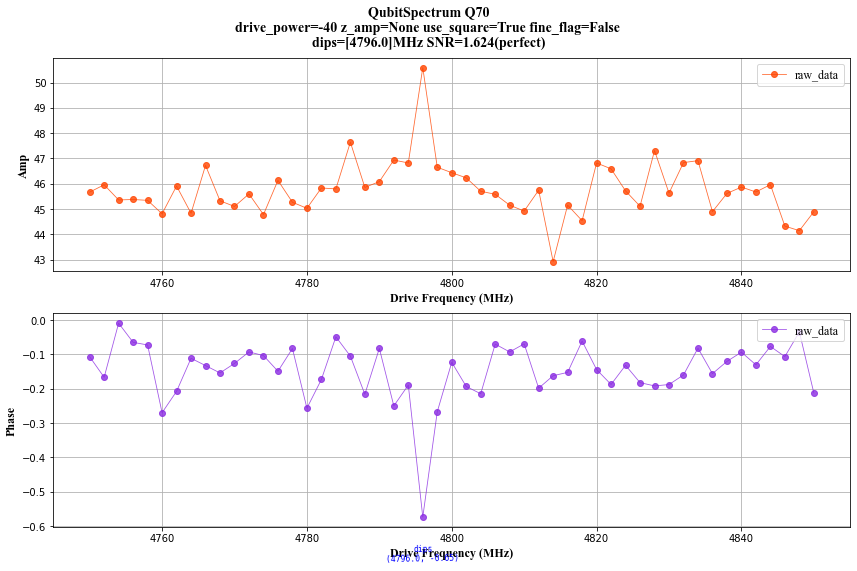

In [35]:
qs_exp.analysis.drawer.figure

### 比特能谱细扫实验

2022-12-11 17:15:39 |   EXP    | QubitSpectrum register success, id 63959fbbd87a606edd99d4fe
2022-12-11 17:15:39 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitSpectrum\q71\2022-12-11\17.15.39\


<IPython.core.display.Javascript object>


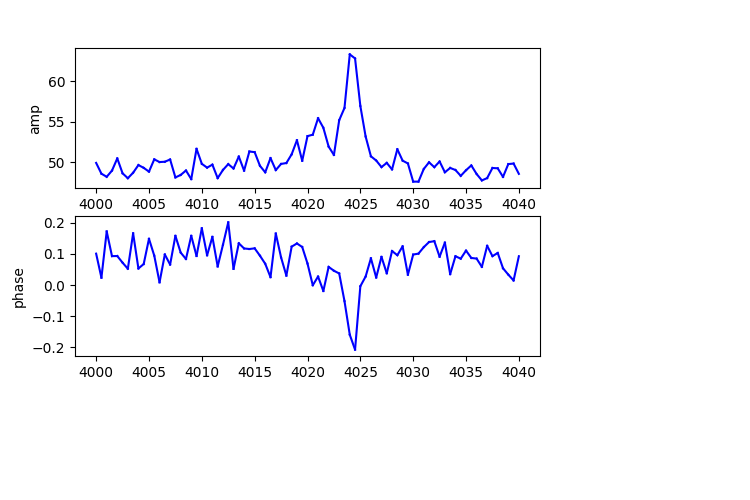

  0%|          | 0/81 [00:00<?, ?it/s]

2022-12-11 17:17:10 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality      | 
---------------------------------------------------------
| freq |   f01    | 4024.189 | MHz  | R²=0.7836(normal) | 


In [21]:
qs_exp2 = QubitSpectrum.from_experiment_context(context)

qs_exp2.set_experiment_options(
    ac_prepare_time=8000,
    freq_list=qarange(4000, 4040, 0.5),
    drive_power=-40,
    z_amp=None,
    use_square=True,
    band_width=10,
    fine_flag=True,
    xpulse_params = {
            "time": 5000,
            "offset": 15,
            "amp": 1,
            "detune": 0,
            "freq": 566.667
        }
#     simulator_data_path='../scripts/simulator/data/QubitSpectrum/5000Mhz/fine/'
)

qs_exp2.set_analysis_options(
    snr_bounds=1.5,
    quality_bounds=[0.8, 0.6, 0.5],
    is_plot=True,
)

qs_exp2.run()

In [61]:
qubit.XYwave.baseband_freq

566.667

### 查看实验结果

In [72]:
pd.DataFrame(qs_exp2.analysis.show_results())

,name,value,unit,extra,quality
0,f01,4624.147,MHz,{},R²=0.9165(perfect)


### 查看实验结果图

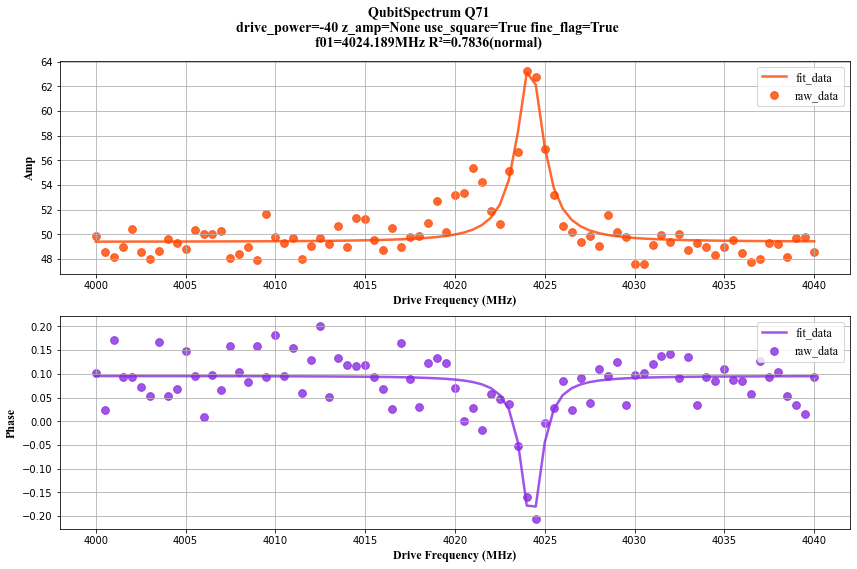

In [22]:
qs_exp2.analysis.drawer.figure

In [19]:
qs_exp2.analysis.results.freq.value

4024.08

## RabiScanWidth

扫描 `Drag` 的脉冲宽度，通过其振荡规律判断比特频率是否正确

2022-12-10 21:48:06 |   EXP    | RabiScanWidth register success, id 63948e16da61ed419364ba26
2022-12-10 21:48:06 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\RabiScanWidth\q71\2022-12-10\21.48.00\


<IPython.core.display.Javascript object>


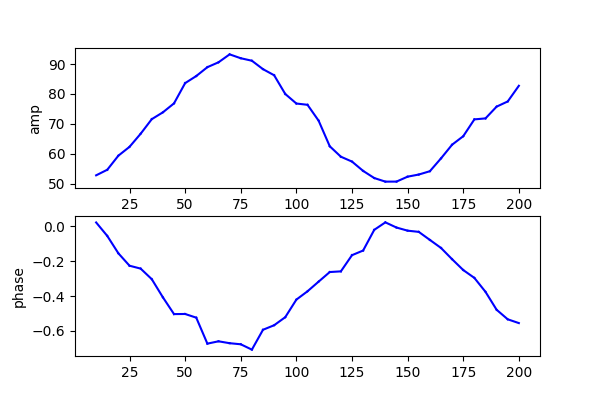

  0%|          | 0/39 [00:00<?, ?it/s]

'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
2022-12-10 21:48:34 |  RESULT  | Experiment results as follow:
|    name     |  describe   | value | unit |      quality       | 
-----------------------------------------------------------------
| oscillating | oscillating | True  | None | R²=0.9897(perfect) | 


In [20]:
rsw = RabiScanWidth.from_experiment_context(context)

rsw.set_experiment_options(
    ac_prepare_time=8000,
    drive_freq=4024.08,
#     drive_freq=4036.526,
    drive_power=-10,
    widths = qarange(10, 200, 5)
#     simulator_data_path='../scripts/simulator/data/RabiScanWidth'
)

rsw.run()

### 检查脉冲时序

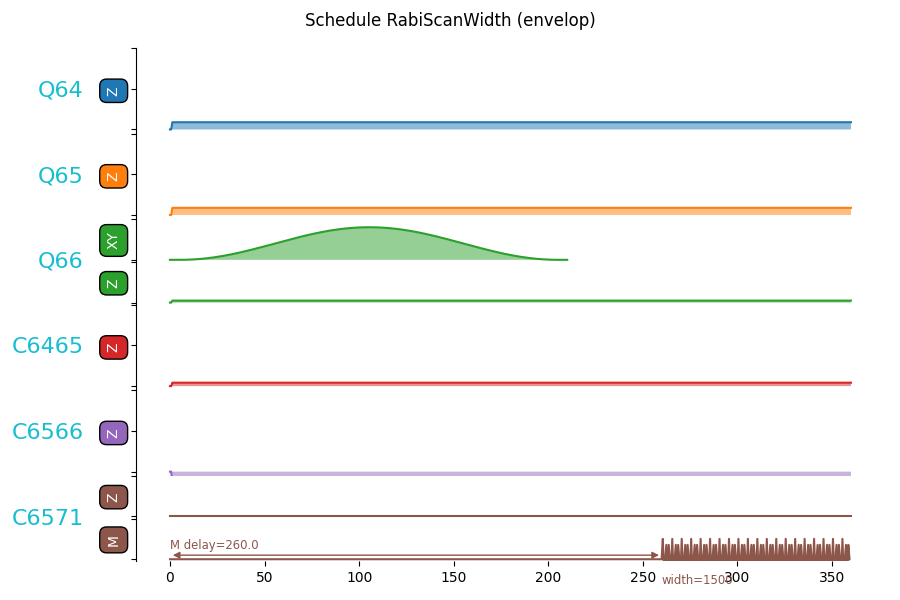

In [101]:
rsw.jupyter_schedule()

### 查看实验结果

In [40]:
pd.DataFrame(rsw.analysis.show_results())

,name,value,unit,extra,quality
0,oscillating,True,None,{},R²=0.9815(perfect)


### 查看实验结果图

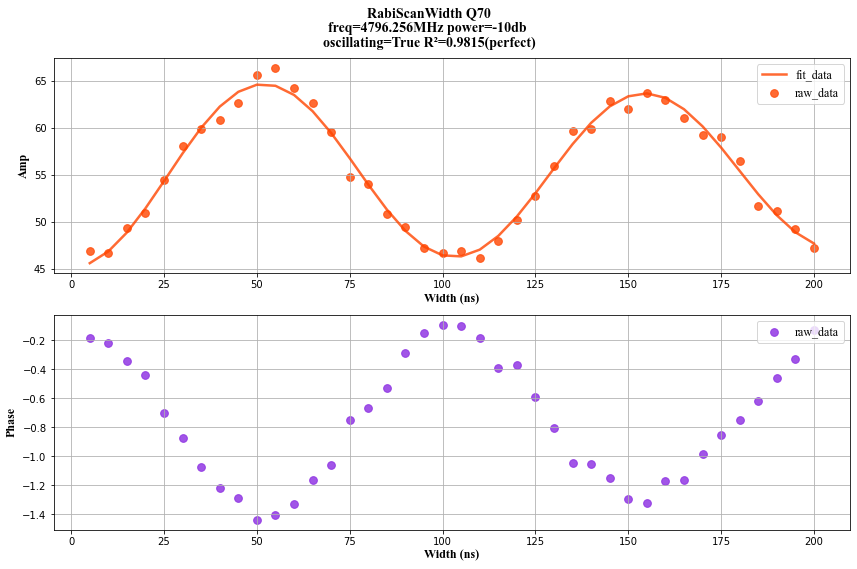

In [41]:
rsw.analysis.drawer.figure

### 根据能谱和 RabiWidth 判断是否更新比特频率

In [21]:
qs_quality = qs_exp2.analysis.quality.descriptor
oscillating = rsw.analysis.results.oscillating.value

if qs_quality in [Quality.perfect, Quality.normal] and oscillating:
    qubit.drive_freq = qs_exp2.analysis.results.freq.value
    qubit.drive_power = qs_exp2.experiment_options.drive_power
    pyqlog.info(f'Update {qubit} drive_freq {qubit.drive_freq}MHz, drive_power {qubit.drive_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-10 21:48:35 |   INFO   | Update Qubit(bit=71) drive_freq 4024.08MHz, drive_power -40db
2022-12-10 21:48:35 |  UPDATE  | Save q71 to data service success.


In [111]:
qubit.drive_freq = 4035.221
qubit.save_data()

2022-11-26 20:40:00 |  UPDATE  | Save q71 to data service success.


### 检索比特参数

In [77]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7126.078,MHz,None
1,probe_power,-28.000,db,None
2,drive_freq,4619.365,MHz,None
3,drive_power,-13.000,db,None


In [22]:
qubit.XYwave.time = 80
# qubit.drive_freq = 4794.108
qubit.save_data()

2022-12-10 21:48:54 |  UPDATE  | Save q71 to data service success.


In [37]:
qubit.XYwave.offset

5.0

## XpiDetection

XpiDetune 实验是对 RabiScanAmp 实验的封装， 扫描 `Drag` 幅值，粗测 `X` 门幅值

2022-12-10 21:50:38 |   EXP    | The expect_value is 0.7.
2022-12-10 21:50:38 |   EXP    | The max test time is 5.
2022-12-10 21:50:38 |   EXP    | RabiScanAmp count 0, drive_power -10
2022-12-10 21:50:45 |   EXP    | RabiScanAmp register success, id 63948eb5da61ed419364bb3a
2022-12-10 21:50:45 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\XpiDetection\q71\2022-12-10\21.50.38\RabiScanAmp\21-50-38-count=0-drive_power=-10\


<IPython.core.display.Javascript object>


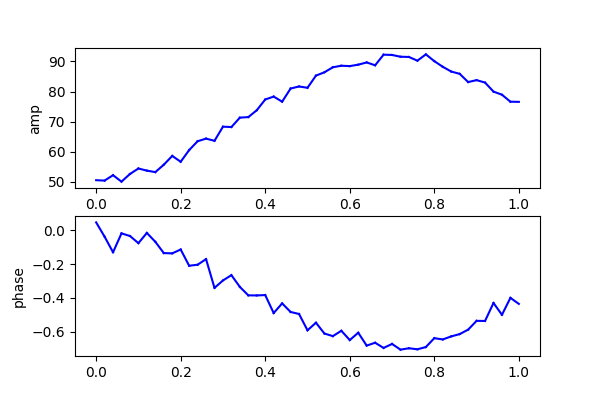

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-10 21:51:22 |  RESULT  | Experiment results as follow:
|    name     | describe | value | unit |      quality       | 
--------------------------------------------------------------
| drive_power |    dp    |  -10  |  db  | R²=0.9935(perfect) | 
|     Xpi     |  X-amp   |  0.7  |  V   | R²=0.9935(perfect) | 
2022-12-10 21:51:22 |  RESULT  | Success, Xpi 0.7, drive_power -10


In [24]:
xd = XpiDetection.from_experiment_context(context)

xd.set_experiment_options(
    amps=qarange(0, 1, 0.02),
    drive_power=-10,
    name="Xpi",
#     simulator_data_path='../scripts/simulator/data/XpiDetection/'
)
xd.child_experiment.set_experiment_options(
    ac_prepare_time=8000,
)
xd.run()

### 查看实验结果

In [46]:
pd.DataFrame(xd.analysis.show_results())

,name,value,unit,extra,quality
0,dp,-10.00,db,{},R²=0.9875(perfect)
1,X-amp,0.82,V,{},R²=0.9875(perfect)


### 查看实验结果图

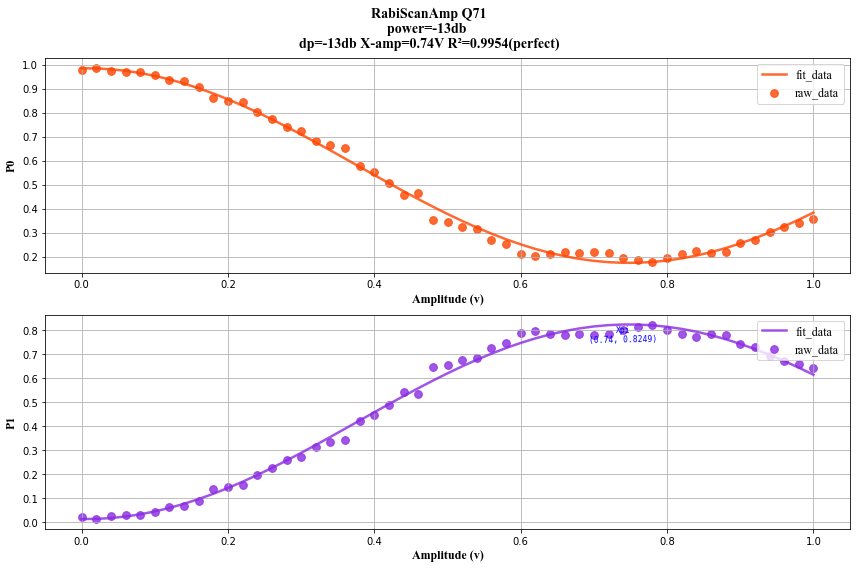

In [41]:
xd.analysis.drawer.figure

### 检查实验质量并更新比特参数

In [25]:
xd_quality = xd.analysis.quality.descriptor
Xpi = xd.analysis.results.Xpi.value
drive_power = xd.analysis.results.drive_power.value

if xd_quality in [Quality.perfect, Quality.normal]:
    qubit.XYwave.Xpi = Xpi
    qubit.XYwave.Xpi2 = round(Xpi / 2, 3)
    qubit.drive_power = drive_power
    pyqlog.info(f'Update {qubit} Xpi {qubit.XYwave.Xpi}v, Xpi2 {qubit.XYwave.Xpi2}v, drive_power {qubit.drive_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-10 21:51:26 |   INFO   | Update Qubit(bit=71) Xpi 0.7v, Xpi2 0.35v, drive_power -10db
2022-12-10 21:51:26 |  UPDATE  | Save q71 to data service success.


In [140]:
bq_ac_list = qarange(0.0, 0.09, 0.01)
bq_ac_list.extend(qarange(0.09, 0.095, 0.001))
bq_ac_list

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.09,
 0.091,
 0.092,
 0.093,
 0.094,
 0.095]

### 检索比特参数，检查是否更新成功

In [63]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.938,MHz,None
1,probe_power,-36.000,db,None
2,drive_freq,4635.704,MHz,None
3,drive_power,-10.600,db,None
4,XYwave.Xpi,0.700,v,None
5,XYwave.Xpi2,0.350,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## ReadoutFreqCalibrate

读取频率优化，此实验执行两次腔能谱实验，第一次不加驱动脉冲测量，第二次加驱动脉冲测量，通过分析两个子实验选择合适的读取频率。

In [53]:
qubit.probe_power = -36
qubit.save_data()

2022-11-23 21:39:48 |  UPDATE  | Save q70 to data service success.


2022-12-10 21:51:37 |   EXP    | CavityFreqSpectrum register success, id 63948ee9da61ed419364bb3c
2022-12-10 21:51:37 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutFreqCalibrate\q71\2022-12-10\21.51.37\CavityFreqSpectrum\21-51-37-xy_pulse amp=0\


<IPython.core.display.Javascript object>


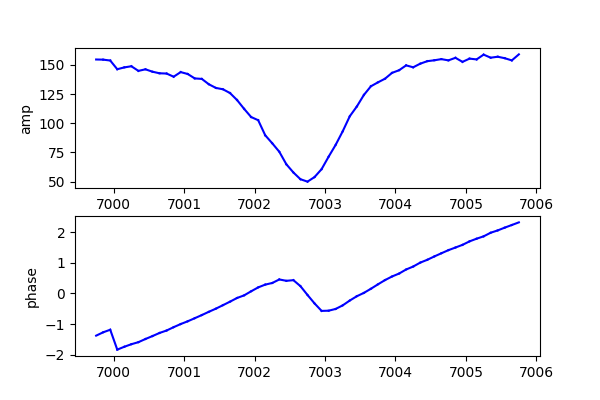

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-10 21:52:19 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7002.742 | MHz  | R²=0.9969(perfect) | 
2022-12-10 21:52:19 |   EXP    | CavityFreqSpectrum register success, id 63948f13da61ed419364bb3e
2022-12-10 21:52:19 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutFreqCalibrate\q71\2022-12-10\21.51.37\CavityFreqSpectrum\21-52-19-xy_pulse amp=0.7\


<IPython.core.display.Javascript object>


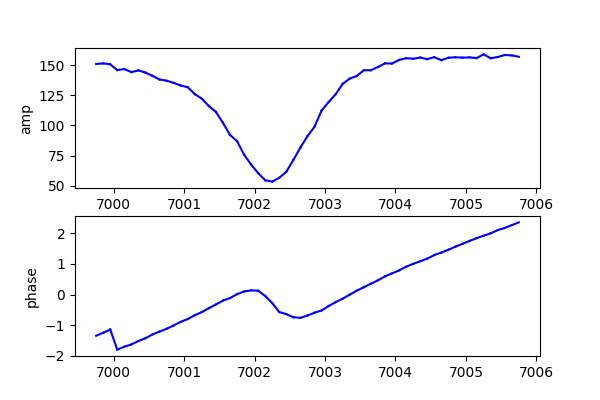

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-10 21:53:02 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality      | 
---------------------------------------------------------
|  fr  |    fc    | 7002.257 | MHz  | R²=0.998(perfect) | 
2022-12-10 21:53:03 |  RESULT  | Experiment results as follow:
|      name       |   describe   |       value       | unit | quality | 
-----------------------------------------------------------------------
|       fr        |  CavityFreq  |     7002.499      | MHz  |  None   | 
|     mean_fr     |     Mean     |     7002.499      | MHz  |  None   | 
|   distance_fr   |   Distance   |     7002.552      | MHz  |  None   | 
| intersection_fr | Intersection |     7002.452      | MHz  |  None   | 
|    distance     | max amp gap  | 72.64197928790388 |  v   |  None   | 
|      shift      |    shift     |       True        | None |  None   | 


In [26]:
rfc = ReadoutFreqCalibrate.from_experiment_context(context)

rfc.set_experiment_options(
#     simulator_data_path='../scripts/simulator/data/ReadoutFreqCalibrate/'
)

rfc.set_analysis_options(
    distance_flag=False, diff_threshold=0.1
)

rfc.child_experiment.set_experiment_options(
    ac_prepare_time=8000,
)

rfc.child_experiment.set_analysis_options(
    quality_bounds=[0.98, 0.95, 0.85], is_plot=True
)

rfc.run()

### 查看实验结果

In [24]:
pd.DataFrame(rfc.analysis.show_results())

,name,value,unit,extra,quality
0,CavityFreq,7125.989,MHz,{},None
1,Mean,7125.989,MHz,{},None
2,Distance,7126.556,MHz,{},None
3,Intersection,7125.856,MHz,{},None
4,max amp gap,59.606364,v,"{'out_flag': False, 'value': array([44.84726533, 56.18723846, 55.14291825, 53.5700713 , 51.64597582, 37.8344856 , 30.78637474, 37.96250174, 13.70481026, 18.00020796, 21.32395372, 30.38133515, 24.23792611, 28.7181158 , 30.33353126, 29.61670126, 35.1996604 , 40.69871 , 39.59711454, 42.6578372 , 42.09339747, 33.67078633, 36.7685736 , 32.15731291, 28.28284684, 23.4555966 , 10.92720655, 5.47504288, 12.0222821 , 21.24754003, 37.04629268, 43.84021598, 57.44887126, 59.60636433, 51.7675272 , 42.33593018, 32.55799593, 27.43287867, 19.79339191, 19.0189728 , 17.65271879, 18.65062815, 20.21783184, 18.41780453, 15.54266929, 17.36913964, 17.30349177, 17.35712012, 11.62460058, 16.06595393, 12.69672452, 11.79856155, 9.91355824, 10.19087743, 10.21197598, 9.39300095, 8.04080005, 10.18352128, 5.5483647 , 11.33566101, 3.70590286])}",None
5,shift,True,None,{},None


### 查看实验结果图

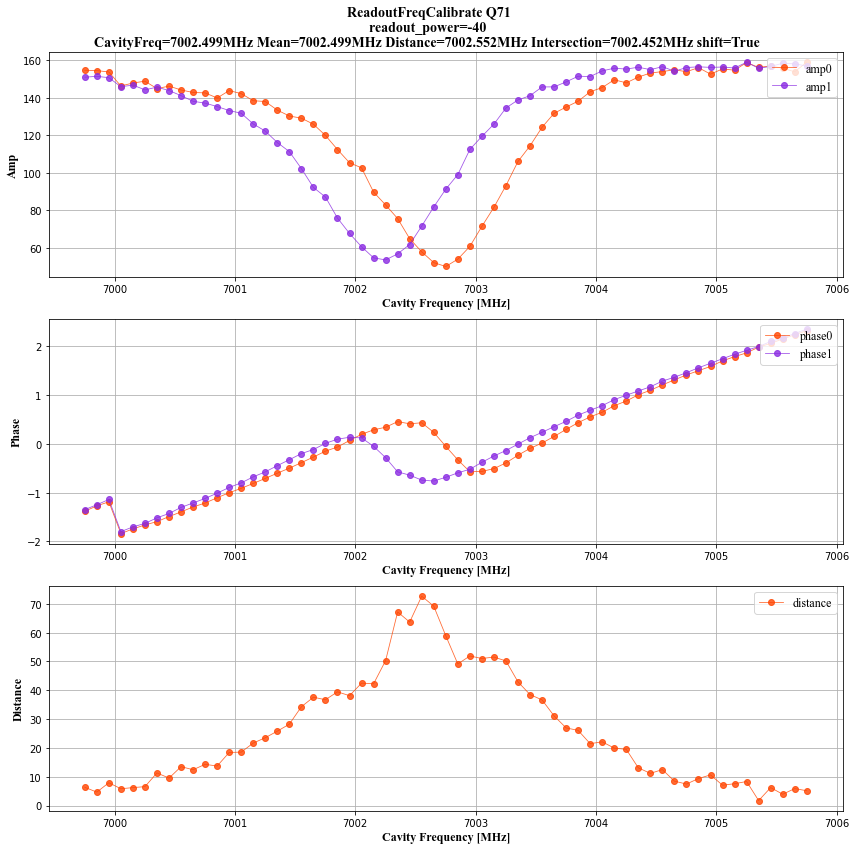

In [27]:
rfc.analysis.drawer.figure

### 更新比特参数

In [23]:
qubit.probe_freq = rfc.analysis.results.fr.value
qubit.save_data()

2022-12-11 17:18:06 |  UPDATE  | Save q71 to data service success.


In [53]:
rfc.analysis.results.keys()

dict_keys(['fr', 'mean_fr', 'distance_fr', 'intersection_fr', 'distance', 'shift'])

### 检索比特参数信息

In [14]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.956,MHz,None
1,probe_power,-36.000,db,None
2,drive_freq,4619.874,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.880,v,None
5,XYwave.Xpi2,0.440,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## ReadoutPowerCalibrate

读取功率优化，此实验固定其他参数，扫描读取频率执行 `SingleShot` 实验，找到 `IQ` 数据分的最开下的读取功率

In [29]:
rpc = ReadoutPowerCalibrate.from_experiment_context(context)

simulator_data_path = []
power_list = qarange(-40, -20, 2)

rpc.set_experiment_options(
    sweep_list=power_list,
#     simulator_data_path='../scripts/simulator/data/ReadoutPowerCalibrate/'
)

rpc.set_analysis_options(
    fidelity_threshold=[0.8, 0.5],
    outlier=0.02,
)

rpc.child_experiment.set_experiment_options(
    repeat=5000,
    ac_prepare_time=8000,
)

rpc.child_experiment.set_analysis_options(
    quality_bounds=[2, 0.85, 0.7, 0.011], is_plot=True, method="GMM"
)

rpc.run()

2022-12-10 21:54:08 |   EXP    | Run SingleShot probe_power: -40
2022-12-10 21:54:08 |   EXP    | SingleShot register success, id 63948f80da61ed419364bb58
2022-12-10 21:54:08 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-08-probe_power=-40\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:54:15 |  RESULT  | Experiment results as follow:
| name | describe |                      value                      | unit |   quality    | 
-------------------------------------------------------------------------------------------
| q71  |   q71    | K=2 F(0, 1)=[0.8272, 0.7766] AVE=0.8019 OL=0.01 | None | {'q71': bad} | 
2022-12-10 21:54:15 |   EXP    | Run SingleShot probe_power: -38
2022-12-10 21:54:16 |   EXP    | SingleShot register success, id 63948f88da61ed419364bb72
2022-12-10 21:54:16 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-15-probe_power=-38\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:54:23 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q71  |   q71    | K=2 F(0, 1)=[0.8512, 0.8168] AVE=0.834 OL=0.0122 | None | {'q71': bad} | 
2022-12-10 21:54:23 |   EXP    | Run SingleShot probe_power: -36
2022-12-10 21:54:23 |   EXP    | SingleShot register success, id 63948f8fda61ed419364bb8c
2022-12-10 21:54:23 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-23-probe_power=-36\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:54:31 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q71  |   q71    | K=2 F(0, 1)=[0.894, 0.8132] AVE=0.8536 OL=0.0102 | None | {'q71': normal} | 
2022-12-10 21:54:31 |   EXP    | Run SingleShot probe_power: -34
2022-12-10 21:54:31 |   EXP    | SingleShot register success, id 63948f97da61ed419364bba6
2022-12-10 21:54:31 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-31-probe_power=-34\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:54:38 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q71  |   q71    | K=2 F(0, 1)=[0.9092, 0.8422] AVE=0.8757 OL=0.0137 | None | {'q71': bad} | 
2022-12-10 21:54:38 |   EXP    | Run SingleShot probe_power: -32
2022-12-10 21:54:39 |   EXP    | SingleShot register success, id 63948f9fda61ed419364bbc0
2022-12-10 21:54:39 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-38-probe_power=-32\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:54:46 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q71  |   q71    | K=2 F(0, 1)=[0.9122, 0.838] AVE=0.8751 OL=0.0155 | None | {'q71': bad} | 
2022-12-10 21:54:46 |   EXP    | Run SingleShot probe_power: -30
2022-12-10 21:54:46 |   EXP    | SingleShot register success, id 63948fa6da61ed419364bbda
2022-12-10 21:54:46 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-46-probe_power=-30\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:54:54 |  RESULT  | Experiment results as follow:
| name | describe |                      value                      | unit |   quality    | 
-------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.88, 0.8684] AVE=0.8742 OL=0.0178 | None | {'q71': bad} | 
2022-12-10 21:54:54 |   EXP    | Run SingleShot probe_power: -28
2022-12-10 21:54:54 |   EXP    | SingleShot register success, id 63948faeda61ed419364bbf4
2022-12-10 21:54:54 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-54-54-probe_power=-28\


  0%|          | 0/2 [00:00<?, ?it/s]

status |1> and |1> are mixed and cannot be distinguished
2022-12-10 21:55:01 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.814, 0.2006] AVE=0.5073 OL=0.0017 | None | {'q71': bad} | 
2022-12-10 21:55:01 |   EXP    | Run SingleShot probe_power: -26
2022-12-10 21:55:02 |   EXP    | SingleShot register success, id 63948fb6da61ed419364bc0e
2022-12-10 21:55:02 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-55-01-probe_power=-26\


  0%|          | 0/2 [00:00<?, ?it/s]

status |1> and |1> are mixed and cannot be distinguished
2022-12-10 21:55:09 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.6306, 0.404] AVE=0.5173 OL=0.0141 | None | {'q71': bad} | 
2022-12-10 21:55:09 |   EXP    | Run SingleShot probe_power: -24
2022-12-10 21:55:10 |   EXP    | SingleShot register success, id 63948fbeda61ed419364bc28
2022-12-10 21:55:10 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-55-09-probe_power=-24\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-10 21:55:17 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.8182, 0.5828] AVE=0.7005 OL=0.0215 | None | {'q71': bad} | 
2022-12-10 21:55:17 |   EXP    | Run SingleShot probe_power: -22
2022-12-10 21:55:17 |   EXP    | SingleShot register success, id 63948fc5da61ed419364bc42
2022-12-10 21:55:17 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-55-17-probe_power=-22\


  0%|          | 0/2 [00:00<?, ?it/s]

status |1> and |1> are mixed and cannot be distinguished
2022-12-10 21:55:25 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.8384, 0.3104] AVE=0.5744 OL=0.0078 | None | {'q71': bad} | 
2022-12-10 21:55:25 |   EXP    | Run SingleShot probe_power: -20
2022-12-10 21:55:25 |   EXP    | SingleShot register success, id 63948fcdda61ed419364bc5c
2022-12-10 21:55:25 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q71\2022-12-10\21.54.08\SingleShot\21-55-25-probe_power=-20\


  0%|          | 0/2 [00:00<?, ?it/s]

status |0> and |0> are mixed and cannot be distinguished
2022-12-10 21:55:32 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.8352, 0.1702] AVE=0.5027 OL=0.0045 | None | {'q71': bad} | 
2022-12-10 21:55:33 |  RESULT  | Experiment results as follow:
|      name      |    describe    | value | unit | quality | 
------------------------------------------------------------
| optimize_field | optimize_field |  -34  | None |  None   | 
| fidelity_flag  | fidelity_flag  | True  | None |  None   | 
|  outlier_flag  |  outlier_flag  | True  | None |  None   | 
|     status     |     status     |   0   | None |  None   | 
2022-12-10 21:55:33 |   FLOW   | Readout Power Calibrate q71 Pass! Readout Power: -34


### 查询实验结果

In [51]:
pd.DataFrame(rpc.analysis.show_results())

,name,value,unit,extra,quality
0,optimize_field,-34,None,{},None
1,fidelity_flag,True,None,{},None
2,outlier_flag,True,None,{},None
3,status,0,None,{},None


### 查询实验结果图

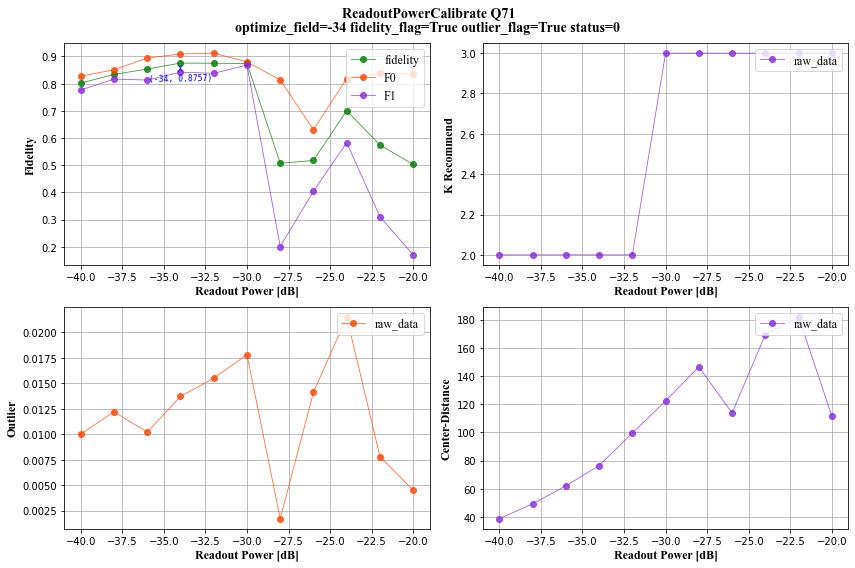

In [30]:
rpc.analysis.drawer.figure

### 查询子实验结果图

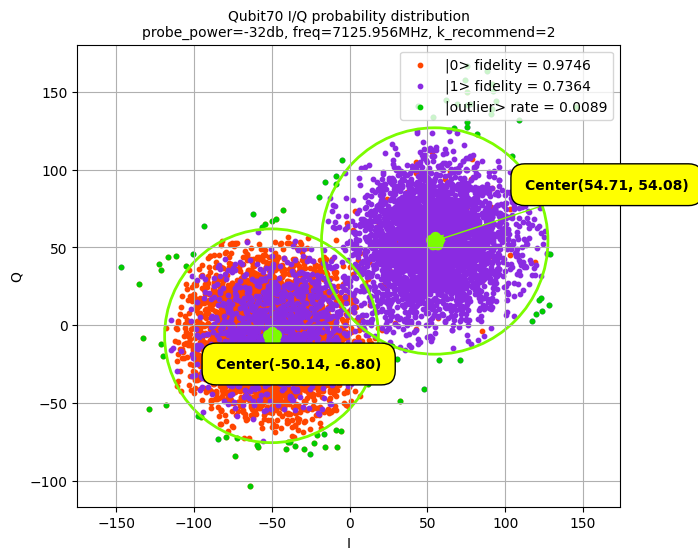

In [17]:
rpc.component_experiment(index=-3).analysis.drawer.figure

### 更新比特参数

In [24]:
qubit.probe_power = -34
qubit.save_data()

2022-12-11 17:18:17 |  UPDATE  | Save q71 to data service success.


In [83]:
type(rpc.analysis.results.optimize_field.value)

numpy.int32

### 检索比特参数

In [7]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.989,MHz,None
1,probe_power,-36.000,db,None
2,drive_freq,4623.719,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.960,v,None
5,XYwave.Xpi2,0.480,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## SampleWidthOptimize

采样宽度优化，此实验固定其他参数，扫描采集宽度执行 `SingleShot` 实验，找到 `IQ` 数据分的最开下的采集宽度

In [ ]:
swo = SampleWidthOptimize.from_experiment_context(context)

simulator_data_path = []
width_list = qarange(800, 2500, 100)

swo.set_experiment_options(
    sweep_list=width_list,
    simulator_data_path='../scripts/simulator/data/SampleWidthOptimize/'
)

swo.set_analysis_options(
    fidelity_threshold=[0.9, 0.8],
    outlier=0.011,
    distance_flag=False,
)

swo.child_experiment.set_experiment_options(repeat=5000)

swo.child_experiment.set_analysis_options(
    quality_bounds=[2, 0.85, 0.7, 0.011], is_plot=True, method="GMM"
)

swo.run()

### 查询实验结果

In [ ]:
pd.DataFrame(swo.analysis.show_results())

### 查询子实验结果图

In [ ]:
swo.component_experiment(5).analysis.drawer.figure

### 查询实验结果图

In [ ]:
swo.analysis.drawer.figure

### 更新比特参数

In [ ]:
qubit.sample_width = 1300
qubit.save_data()

### 检索比特信息

In [ ]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave', 'sample_width']
    )
)

## SingleShot

获取 `IQ` 分类器

In [25]:
context.discriminators = None

In [26]:
ss = SingleShot.from_experiment_context(context)

ss.set_experiment_options(
    ac_prepare_time=8000,
    repeat=5000,
    is_check=False,
    save_bin=True,
#     simulator_data_path='../scripts/simulator/data/SingleShot/'
)

ss.set_analysis_options(
    method="GMM", quality_bounds=[2, 0.80, 0.65, 0.011], is_plot=True
)

ss.run()

2022-12-11 17:19:14 |   EXP    | SingleShot register success, id 6395a092d87a606edd99d518
2022-12-11 17:19:14 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\SingleShot\q71\2022-12-11\17.19.14\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-11 17:20:10 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q71  |   q71    | K=3 F(0, 1)=[0.911, 0.8598] AVE=0.8854 OL=0.0125 | None | {'q71': bad} | 
2022-12-11 17:20:10 |  UPDATE  | Save q71.bin to data service success.


### 查询实验结果

In [130]:
pd.DataFrame(ss.analysis.show_results())

,name,value,unit,extra,quality
0,q70,K=2 F0=0.9512 F1=0.8274 AVE=0.8893 OL=0.0102,None,{},{'q70': normal}


### 查询实验结果图

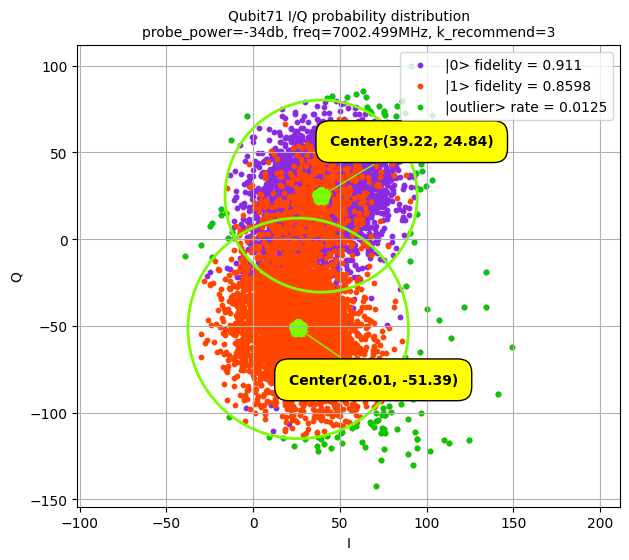

In [27]:
ss.analysis.drawer.figure

### 为当前实验环境绑定比特判据

In [28]:
context.configure_dcm(q_name)

IQdiscriminator<center=[[ 26.00791499 -51.39183323]
 [ 39.21560811  24.84435855]]>

### 检索当前实验环境中的系统参数

In [133]:
pd.DataFrame(context.context_table())

,parameter,object,count
0,config,F:\MonsterTest_QT8013\conf\config.conf,
1,qubits,[Qubit(bit=70)],1
2,couplers,[],0
3,discriminators,None,0
4,compensates,"{Qubit(bit=64): PulseCorrectionQ64, Qubit(bit=65): PulseCorrectionQ65, Qubit(bit=69): PulseCorrectionQ69, Qubit(bit=71): PulseCorrectionQ71, Qubit(bit=72): PulseCorrectionQ72, Coupler(bit=6470, driveQ64, probeQ70): PulseCorrectionC6470, Coupler(bit=6571, driveQ65, probeQ71): PulseCorrectionC6571, Coupler(bit=6970, driveQ69, probeQ70): PulseCorrectionC6970, Coupler(bit=7071, driveQ70, probeQ71): PulseCorrectionC7071, Coupler(bit=7172, driveQ71, probeQ72): PulseCorrectionC7172, Qubit(bit=70): PulseCorrectionQ70}",11
5,working_dc,True,
6,crosstalk_dict,True,


## DriveFreqCalibrate


驱动频率校准实验，该实验通过执行两次 `Ramsey` 实验，精细校准比特的驱动频率

In [ ]:
set_subanalysis_options(is_plot=True)

2022-12-11 17:25:24 |   EXP    | Ramsey register success, id 6395a204d87a606edd99d64d
2022-12-11 17:25:24 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitFreqCalibration\q71\2022-12-11\17.25.14\Ramsey\17-25-14-fringe=80MHz\


<IPython.core.display.Javascript object>


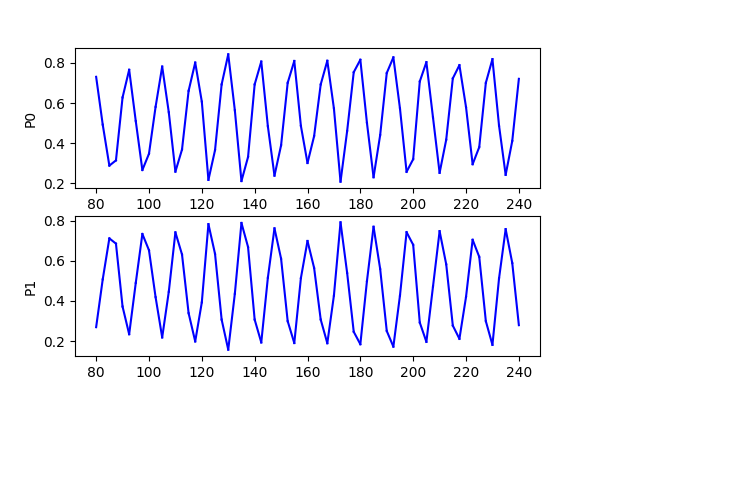

  0%|          | 0/65 [00:00<?, ?it/s]

2022-12-11 17:26:42 |   EXP    | Ramsey register success, id 6395a252d87a606edd99d6b4
2022-12-11 17:26:42 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitFreqCalibration\q71\2022-12-11\17.25.14\Ramsey\17-26-32-fringe=-80MHz\


<IPython.core.display.Javascript object>


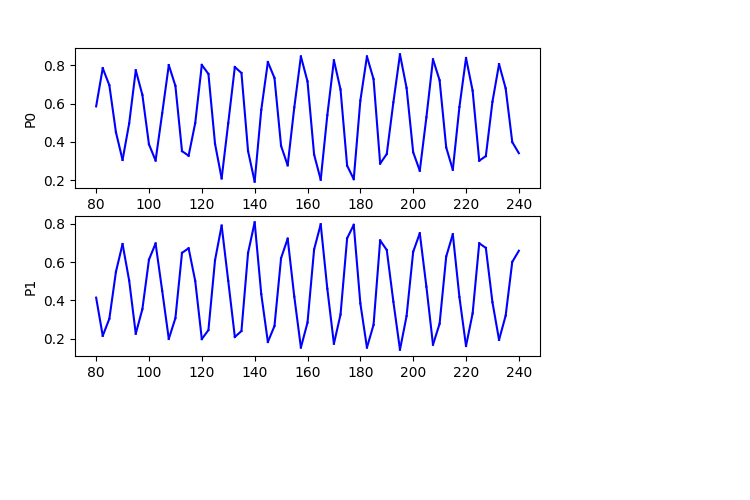

  0%|          | 0/65 [00:00<?, ?it/s]

2022-12-11 17:28:35 |  RESULT  | Experiment results as follow:
|      name       |    describe     |                              value                              | unit |   quality   | 
----------------------------------------------------------------------------------------------------------------------------
|   f01_records   |   f01_records   | [3863.4991600000003, 4023.4484999999995, 4023.89084, 4183.9415] | MHz  | Quality.bad | 
|       f01       |       f01       |                             4023.67                             | MHz  | Quality.bad | 
| minimum_f01_gap | minimum_f01_gap |                              0.442                              | MHz  | Quality.bad | 


In [30]:
qfc = QubitFreqCalibration.from_experiment_context(context)

qfc.set_experiment_options(
    fringes=[80, -80],
    delays=qarange(80, 240, 2.5),
#     simulator_data_path='../scripts/simulator/data/QubitFreqCalibration/',
    show_result=True,
    
    
)

qfc.set_analysis_options(freq_gap_threshold=0.2,
                         is_plot=True)

qfc.child_experiment.set_analysis_options(
    quality_bounds=[0.98, 0.9, 0.8],
    is_plot=True
)
qfc.child_experiment.set_experiment_options(is_dynamic=1,ac_prepare_time=8000,)
qfc.run()

### 检索子实验的脉冲时序图

In [ ]:
qfc.component_experiment(index=0).jupyter_schedule()

### 查询实验结果图

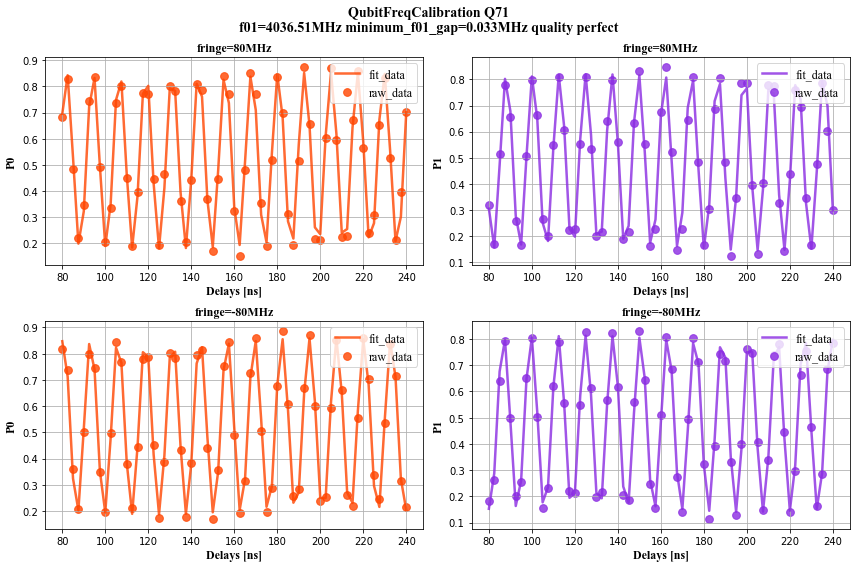

In [130]:
qfc.analysis.drawer.figure

### 更新比特参数

In [37]:
qfc_quality = qfc.analysis.quality.value
f01 = qfc.analysis.results.f01.value
if qfc_quality == Quality.perfect:
    qubit.drive_freq = f01
    pyqlog.info(f'Update {qubit} drive_freq {qubit.drive_freq}MHz!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-10 22:02:33 |   INFO   | Update Qubit(bit=71) drive_freq 4023.695MHz!
2022-12-10 22:02:33 |  UPDATE  | Save q71 to data service success.


In [47]:
qubit.drive_freq = 4036.37
qubit.save_data()

2022-11-24 17:02:42 |  UPDATE  | Save q71 to data service success.


### 检索比特信息

In [21]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave', 'sample_width']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.956,MHz,None
1,probe_power,-32.000,db,None
2,drive_freq,4619.130,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.880,v,None
5,XYwave.Xpi2,0.440,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## DetuneCalibration

DetuneCalibration 实验，精细校准失谐量 `detune`

2022-12-01 21:12:28 |   EXP    | theta_type: Xpi, N: 6
2022-12-01 21:12:31 |   EXP    | APE register success, id 6388a83f4c972a4be2495b63
2022-12-01 21:12:31 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q71\2022-12-01\21.12.28\APEComposite\21-12-28-RoughScan\APE\21-12-28-N=6\


<IPython.core.display.Javascript object>


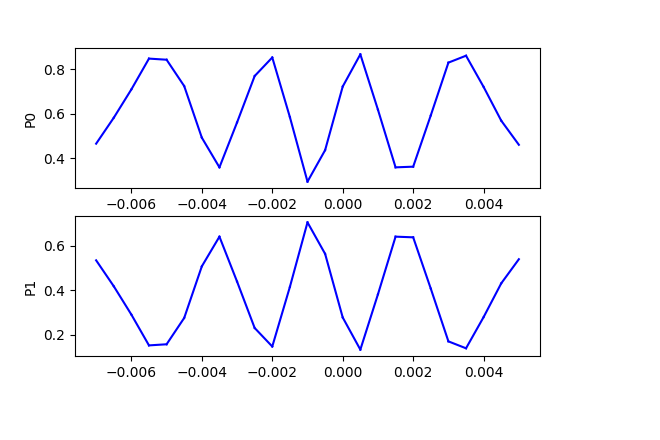

  0%|          | 0/25 [00:00<?, ?it/s]

2022-12-01 21:12:55 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                      value                      | unit |       quality       | 
--------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.0055, -0.002, 0.0005, 0.0035] | None | R²=0.8207(abnormal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.005, -0.0025, 0.0005, 0.0035] | None | R²=0.8207(abnormal) | 
2022-12-01 21:12:55 |   EXP    | theta_type: Xpi, N: 7
2022-12-01 21:12:58 |   EXP    | APE register success, id 6388a85a4c972a4be2495b9e
2022-12-01 21:12:58 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q71\2022-12-01\21.12.28\APEComposite\21-12-28-RoughScan\APE\21-12-55-N=7\


<IPython.core.display.Javascript object>


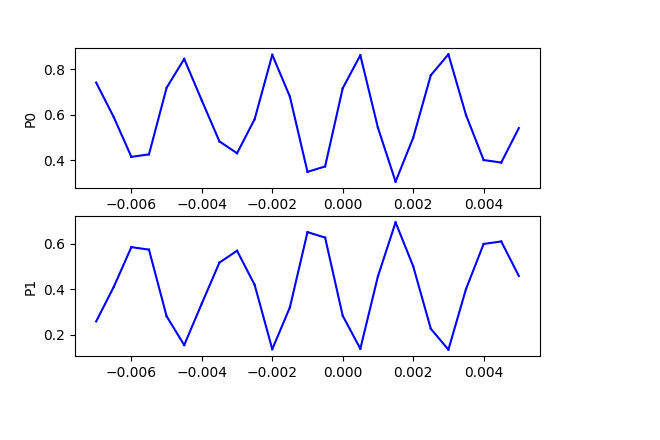

  0%|          | 0/25 [00:00<?, ?it/s]

2022-12-01 21:13:51 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                     value                      | unit |       quality       | 
-------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.0045, -0.002, 0.0005, 0.003] | None | R²=0.8964(abnormal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.0045, -0.002, 0.0005, 0.003] | None | R²=0.8964(abnormal) | 
2022-12-01 21:13:51 |   EXP    | theta_type: Xpi, N: 8
2022-12-01 21:13:54 |   EXP    | APE register success, id 6388a8924c972a4be2495bd9
2022-12-01 21:13:54 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q71\2022-12-01\21.12.28\APEComposite\21-12-28-RoughScan\APE\21-13-51-N=8\


<IPython.core.display.Javascript object>


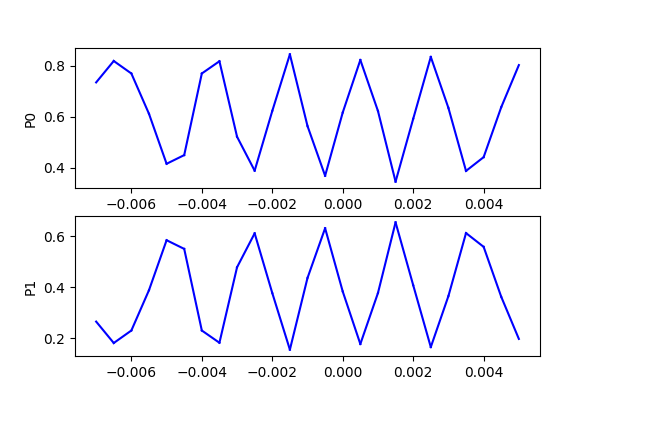

  0%|          | 0/25 [00:00<?, ?it/s]

2022-12-01 21:14:47 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                          value                          | unit |    quality     | 
-----------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   |    detune peaks: [-0.0035, -0.0015, 0.0005, 0.0025]     | None | R²=0.6701(bad) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.006, -0.004, -0.0015, 0.0005, 0.0025] | None | R²=0.6701(bad) | 
2022-12-01 21:14:48 |   EXP    | theta_type: Xpi, N: 7
2022-12-01 21:14:51 |   EXP    | APE register success, id 6388a8cb4c972a4be2495c1f
2022-12-01 21:14:51 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q71\2022-12-01\21.12.28\APEComposite\21-14-48-FineScan\APE\21-14-48-N=7\


<IPython.core.display.Javascript object>


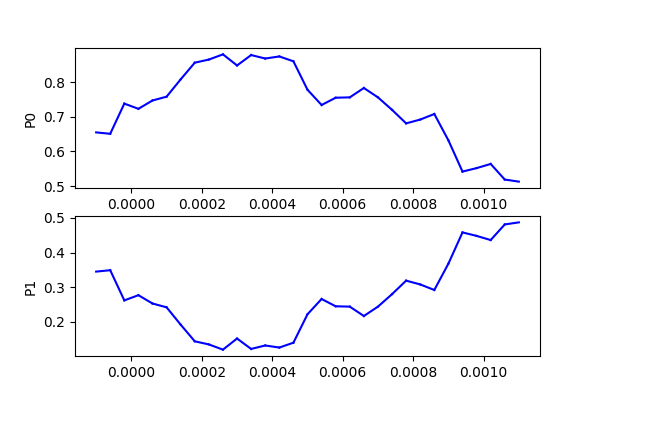

  0%|          | 0/31 [00:00<?, ?it/s]

2022-12-01 21:15:48 |  RESULT  | Experiment results as follow:
|     name     |   describe   |          value          | unit |      quality      | 
------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [0.00026] | None | R²=0.9353(normal) | 
| fit_points_0 | fit_points_0 | detune peaks: [0.00038] | None | R²=0.9353(normal) | 
2022-12-01 21:15:48 |   EXP    | theta_type: Xpi, N: 9
2022-12-01 21:15:52 |   EXP    | APE register success, id 6388a9084c972a4be2495c65
2022-12-01 21:15:52 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q71\2022-12-01\21.12.28\APEComposite\21-14-48-FineScan\APE\21-15-48-N=9\


<IPython.core.display.Javascript object>


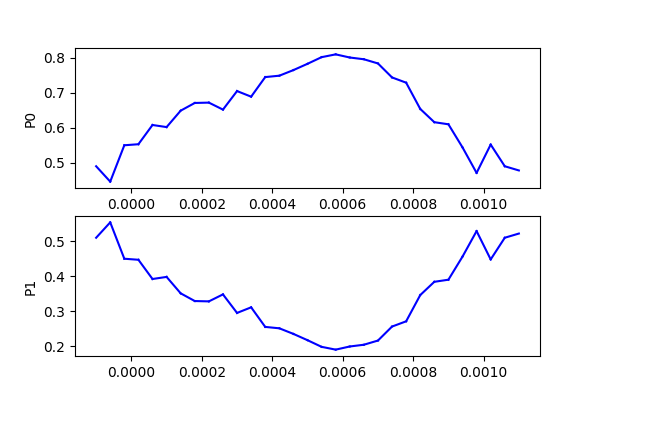

  0%|          | 0/31 [00:00<?, ?it/s]

2022-12-01 21:16:48 |  RESULT  | Experiment results as follow:
|     name     |   describe   |          value          | unit |      quality      | 
------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [0.00058] | None | R²=0.9394(normal) | 
| fit_points_0 | fit_points_0 | detune peaks: [0.0005]  | None | R²=0.9394(normal) | 
2022-12-01 21:16:49 |  RESULT  | Experiment results as follow:
|  name  | describe | value | unit |    quality    | 
----------------------------------------------------
| detune |  detune  |  0.0  | GHz  | evaluate good | 


In [11]:
dec = DetuneCalibration.from_experiment_context(context)

dec.set_experiment_options(
    
    detune_list=qarange(-7e-3, 5e-3, 0.5e-3),
    rough_n_list=[6, 7, 8],
    fine_n_list=[7, 9],
    theta_type="Xpi",
    fine_precision=0.2e-3,
#     simulator_data_path='../scripts/simulator/data/DetuneCalibration/'
)

dec.set_analysis_options(diff_threshold=0.2)
dec.child_experiment.child_experiment.set_experiment_options(ac_prepare_time=8000,)


dec.run()

In [57]:
dec.child_experiment

### 查询实验结果

In [13]:
pd.DataFrame(dec.analysis.show_results())

,name,value,unit,extra,quality
0,detune,0.0,GHz,{},evaluate good


### 查询实验结果图

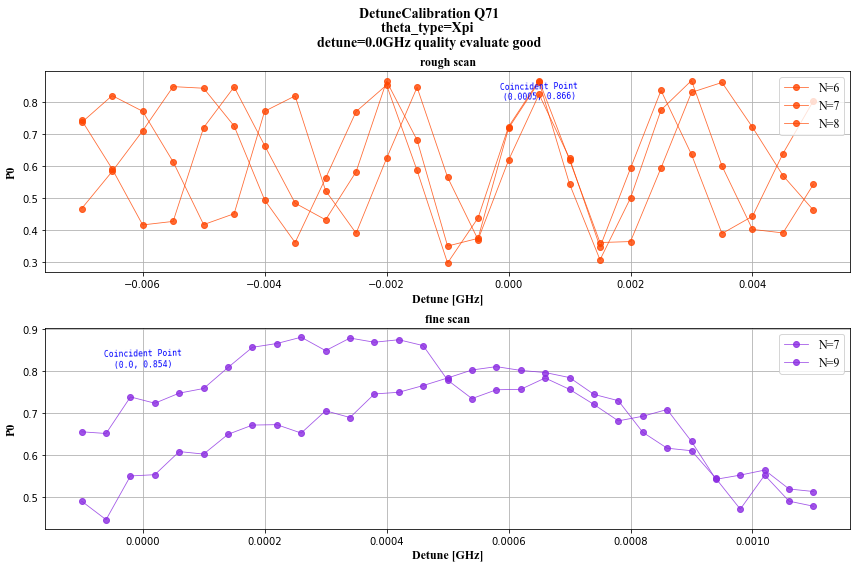

In [12]:
dec.analysis.drawer.figure

In [18]:
qubit.XYwave.detune_pi = 0.
qubit.XYwave.detune_pi2 = 0.
pyqlog.info(f'Update {qubit} detune_pi {qubit.XYwave.detune_pi}MHz!')
qubit.save_data()

2022-12-01 21:22:09 |   INFO   | Update Qubit(bit=71) detune_pi 0.0MHz!
2022-12-01 21:22:09 |  UPDATE  | Save q71 to data service success.


In [64]:
dec.analysis.quality

'evaluate good'

In [14]:
dec.analysis.results.detune.value

0.0

### 更新比特参数信息

In [56]:
detune_pi = dec.analysis.results.detune.value * 1e3
if 'evaluate good' in dec.analysis.quality:
    qubit.XYwave.detune_pi = detune_pi
    qubit.XYwave.detune_pi2 = detune_pi
    pyqlog.info(f'Update {qubit} detune_pi {qubit.XYwave.detune_pi}MHz!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-24 17:06:44 |   INFO   | Update Qubit(bit=71) detune_pi -3.0MHz!
2022-11-24 17:06:44 |  UPDATE  | Save q71 to data service success.


### 检索比特信息

In [25]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave', 'sample_width']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.956,MHz,None
1,probe_power,-32.000,db,None
2,drive_freq,4619.130,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.880,v,None
5,XYwave.Xpi2,0.440,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## AmpOptimize

幅值优化实验，改实验通过微调 X 门驱动幅值，精细校准 X 门幅值

2022-12-10 22:08:38 |   EXP    | theta_type: Xpi, N: 7
2022-12-10 22:08:45 |   EXP    | AmpOptimize register success, id 639492edda61ed419364bdaf
2022-12-10 22:08:45 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\AmpOptimize\q71\2022-12-10\22.08.38\


<IPython.core.display.Javascript object>


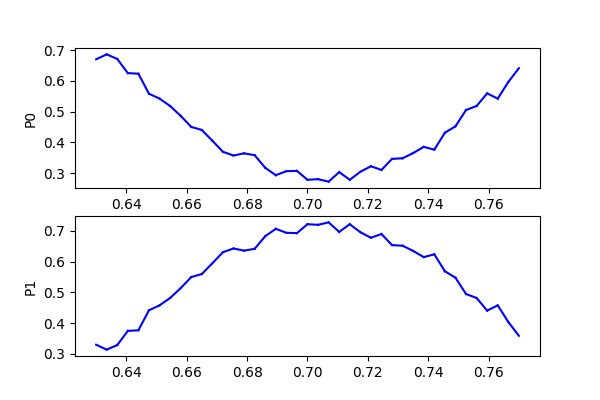

  0%|          | 0/41 [00:00<?, ?it/s]

2022-12-10 22:09:15 |  RESULT  | Experiment results as follow:
| name | describe | value | unit |      quality       | 
-------------------------------------------------------
| Xpi  |  X-amp   | 0.707 |  V   | R²=0.9867(perfect) | 


In [43]:
ao = AmpOptimize.from_experiment_context(context)
ao.set_experiment_options(
    ac_prepare_time=8000,
    theta_type="Xpi", N=7,
    points=41,
#     simulator_data_path='../scripts/simulator/data/AmpOptimize/'
)

ao.run()

### 查询脉冲时序图

In [ ]:
ao.jupyter_schedule()

### 查询实验结果

In [159]:
pd.DataFrame(ao.analysis.show_results())

,name,value,unit,extra,quality
0,X-amp,0.82,V,{},R²=0.9697(normal)


### 查询实验结果图

In [ ]:
ao.analysis.drawer.figure

### 更新比特参数

In [44]:
ao_quality = ao.analysis.quality.descriptor
Xpi = ao.analysis.results.Xpi.value

if ao_quality == Quality.perfect:
    qubit.XYwave.Xpi = Xpi
    pyqlog.info(f'Update {qubit} Xpi {qubit.XYwave.Xpi}V!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-10 22:09:20 |   INFO   | Update Qubit(bit=71) Xpi 0.707V!
2022-12-10 22:09:20 |  UPDATE  | Save q71 to data service success.


In [89]:
qubit.XYwave.Xpi = 0
qubit.save_data()

2022-11-23 21:57:40 |  UPDATE  | Save q70 to data service success.


In [ ]:
# ao_quality = ao.analysis.quality.descriptor
# Xpi2 = ao.analysis.results.Xpi2.value

# if ao_quality == Quality.perfect:
#     qubit.XYwave.Xpi2 = Xpi2
#     pyqlog.info(f'Update {qubit} Xpi2 {qubit.XYwave.Xpi2}V!')
#     qubit.save_data()
# else:
#     pyqlog.info(f'Experiment results bad, please check!')

### 检索比特参数

In [161]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'sample_width', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7126.303,MHz,None
1,probe_power,-28.000,db,None
2,drive_freq,4796.587,MHz,None
3,drive_power,-10.000,db,None
4,sample_width,1000.000,ns,None
5,XYwave.Xpi,0.820,v,None
6,XYwave.Xpi2,0.410,v,None
7,XYwave.Ypi,NaN,v,None
8,XYwave.Ypi2,NaN,v,None
9,XYwave.Zpi,NaN,v,None


## T1

测量比特纵向退相干时间 `T1`

2022-11-24 17:57:10 |   EXP    | T1 register success, id 637f3ff6c88c5b74c452983e
2022-11-24 17:57:10 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\T1\q71\2022-11-24\17.57.05\


<IPython.core.display.Javascript object>


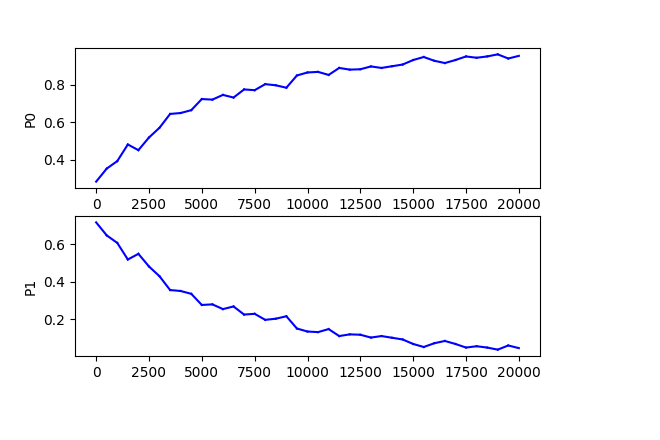

  0%|          | 0/41 [00:00<?, ?it/s]

2022-11-24 17:58:19 |  RESULT  | Experiment results as follow:
| name | describe | value  | unit |      quality       | 
--------------------------------------------------------
| tau  |    T1    | 5.6745 |  us  | R²=0.9905(perfect) | 
| rate |   rate   | 0.284  | None | R²=0.9905(perfect) | 


In [66]:
t1_exp = T1.from_experiment_context(context)
t1_exp.set_experiment_options(
    delay_list=qarange(0, 20000, 500),
#     simulator_data_path='../scripts/simulator/data/T1/'
)

t1_exp.run()

### 查看实验结果

In [ ]:
pd.DataFrame(t1_exp.analysis.show_results())

### 查看实验脉冲时序图

In [ ]:
t1_exp.jupyter_schedule()

### 查看实验结果图

In [ ]:
t1_exp.analysis.drawer.figure

### 更新比特参数

In [ ]:
t1_quality = t1_exp.analysis.quality.descriptor
t1 = t1_exp.analysis.results.tau.value * 1e3

if t1_quality == Quality.perfect:
    qubit.T1 = t1
    pyqlog.info(f'Update {qubit} T1 {qubit.T1}ns!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

In [ ]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'sample_width', 'XYwave', 'T1']
    )
)

## T2

测量比特横向退相干时间 `T2`

2022-12-10 22:09:48 |   EXP    | rate_down: 0.3, rate_up: 0.5, max_loops: 1
2022-12-10 22:09:48 |   EXP    | T2Ramsey count: 0, z_amp: None v, fringe: 558.667 MHz
2022-12-10 22:10:15 |   EXP    | Ramsey register success, id 63949347da61ed419364be54
2022-12-10 22:10:15 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\T2Ramsey\q71\2022-12-10\22.09.48\Ramsey\22-09-48-count=0-z_amp=None-fringe=558.667\


<IPython.core.display.Javascript object>


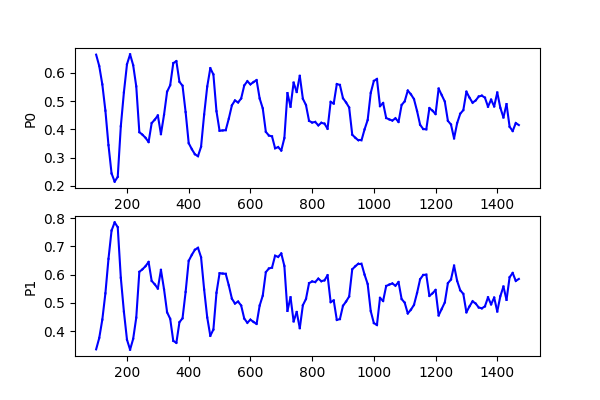

  0%|          | 0/191 [00:00<?, ?it/s]


KeyboardInterrupt



In [48]:
t2_exp = T2Ramsey.from_experiment_context(context)
t2_exp.set_experiment_options(
    
    delays=qarange(100, 2000, 10),
    fringe=566.667 - 8,
    max_loops=1
#     simulator_data_path='../scripts/simulator/data/T2/'
)

t2_exp.run()

### 查询实验结果

In [170]:
pd.DataFrame(t2_exp.analysis.show_results())

,name,value,unit,extra,quality
0,T2star,8.051146,us,{},R²=0.9599(normal)
1,fosc,1.015510,MHz,{},R²=0.9599(normal)
2,t2_rate,0.619319,None,{},R²=0.9599(normal)


### 查询实验脉冲时序图

In [ ]:
t2_exp.jupyter_schedule()

### 查询实验结果图

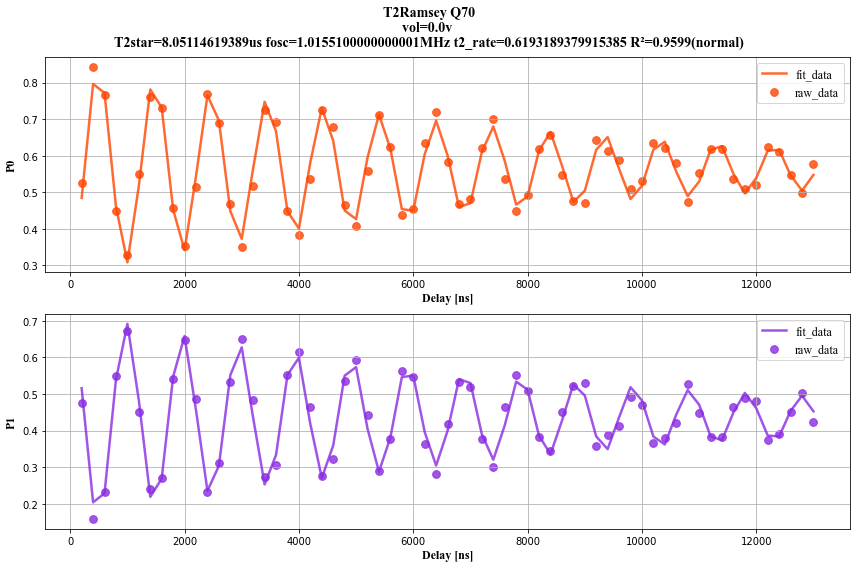

In [172]:
t2_exp.analysis.drawer.figure

### 更新比特参数

In [173]:
t2 = t2_exp.analysis.results.tau.value * 1e3
qubit.T2 = t2
pyqlog.info(f'Update {qubit} T2 {qubit.T2}ns!')
qubit.save_data()

2022-11-21 21:34:22 |   INFO   | Update Qubit(bit=70) T2 8051.14619389ns!
2022-11-21 21:34:22 |  UPDATE  | Save q70 to data service success.


In [176]:
t2_quality = t2_exp.analysis.quality.descriptor
t2 = t2_exp.analysis.results.tau.value * 1e3

if t2_quality == Quality.normal:
    qubit.T2 = t2
    pyqlog.info(f'Update {qubit} T2 {qubit.T2}ns!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-21 21:35:30 |   INFO   | Update Qubit(bit=70) T2 8051.14619389ns!
2022-11-21 21:35:30 |  UPDATE  | Save q70 to data service success.


### 检索比特参数

In [ ]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=[
            'probe_freq', 'probe_power', 'drive_freq', 'drive_power', 
            'sample_width', 'XYwave', 'T1', 'T2']
    )
)

## RB

`Randomized Benchmarking` 来标定单量子比特门保真度

In [ ]:
rb_exp = RBSingle.from_experiment_context(context)
rb_exp.set_experiment_options(
    depths=np.hstack(
        [
            np.arange(2, 10, 2),
            np.arange(10, 50, 5),
            np.arange(50, 100, 10),
            np.arange(100, 400, 20)
        ]
    ).tolist(),
    times=30,
    gate_split=False,
    simulator_data_path='../scripts/simulator/data/RB/',
    schedule_index=[0]
)

rb_exp.run()

### 查询脉冲时序图

In [ ]:
rb_exp.jupyter_schedule()

### 查询实验结果

In [ ]:
pd.DataFrame(rb_exp.analysis.show_results())

### 查询实验结果图

In [ ]:
rb_exp.analysis.drawer.figure

## QPT

`Quantum Process Tomography` 来标定单量子比特门保真度

In [ ]:
qpt_exp = ProcessTomography.from_experiment_context(context)

# simulator_data_path = '../scripts/simulator/data/ProcessTomography/SingleQubit/IGate/'

qpt_exp.set_experiment_options(
    goal_gate='I',
    qubit_nums=1,
#     simulator_data_path=simulator_data_path,
    show_result=False
)
qpt_exp.set_analysis_options(use_mle=True)

qpt_exp.run()

### 查询实验结果

In [184]:
pd.DataFrame(qpt_exp.analysis.show_results())

,name,value,unit,extra,quality
0,exp_chi_matrix,"[[(0.9706715540290267+0j), (-0.004903478726626465+0.0013889376238252172j), (0.0038213824260574275+0.02152924865007118j), (0.01150322537775094+0.01029832072806378j)], [(-0.004903478726626465-0.0013889376238252172j), (0.009051535695919558+0j), (0.003639700967113148-0.011479599597458354j), (0.0022044612493094438+0.0038328322790318493j)], [(0.0038213824260574275-0.02152924865007118j), (0.003639700967113148+0.011479599597458354j), (0.01739622151458492+0j), (-0.004133717366386706+0.004872321193665304j)], [(0.01150322537775094-0.01029832072806378j), (0.0022044612493094438-0.0038328322790318493j), (-0.004133717366386706-0.004872321193665304j), (0.003049606626317272+0j)]]",None,{},None
1,ideal_chi_matrix,"[[(1.0000000000000004+8.896076791452605e-17j), (-3.691512718008711e-16-1.6987262336050975e-16j), (-1.7034584494356492e-16+1.9313783985913177e-16j), (2.683038976177461e-16+2.5110201167889545e-16j)], [(3.5168909705432314e-16+9.364043526578366e-17j), (-1.2601442290656783e-16+2.774675023637665e-17j), (2.868624899295446e-16-6.81859201523387e-16j), (-3.6995586895202886e-16-4.135709452965771e-17j)], [(-1.2805663994388442e-16+3.6277826960460415e-16j), (2.66414084600553e-16-5.39386125564285e-16j), (-1.2601442290656744e-16-4.819515556536797e-17j), (1.8033998068001015e-16-4.698889988642635e-16j)], [(-5.088522196198632e-16-3.1816568570081174e-16j), (1.5820466489607833e-16+1.416984842921471e-16j), (1.9851998401192817e-16-2.7870694560655994e-16j), (1.5728159515523054e-16-2.1897093892609826e-17j)]]",None,{},None
2,fidelity,98.523,%,{},None
3,process_fidelity,97.051,%,{},None


### 查询实验结果图

In [ ]:
qpt_exp.analysis.drawer.figure

### 查询子实验结果图

In [ ]:
qpt_exp.component_experiment(index=3).analysis.drawer.figure

In [ ]:
## 查询数据库中最新的比特信息 

pd.DataFrame(context.base_qubit_table(context.get_qubit(qubit.name)))

## ACSpectrum

In [ ]:
ACS_exp = ACSpectrum.from_experiment_context(context)
ACS_exp.set_experiment_options(
    z_amps=qarange(0, 0.08, 0.001),
    delays = qarange(80, 160, 2.5),
    init_fringe = 80,
    osc_freq_limit = 50,
    freq_bound = 4000,
#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)
ACS_exp.child_experiment.set_experiment_options(
    is_dynamic=False,
    repeat=700)

ACS_exp.run()

### 查询实验结果

In [20]:
pd.DataFrame(ACS_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fq_max,4795.972473,None,{},R²=1.0(perfect)
1,detune,-2017.539422,None,{},R²=1.0(perfect)
2,M,4.565931,None,{},R²=1.0(perfect)
3,offset,-0.000625,None,{},R²=1.0(perfect)
4,d,0.180620,None,{},R²=1.0(perfect)


In [46]:
ACS_exp.analysis.show_results()['value']

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

### 查询实验结果图

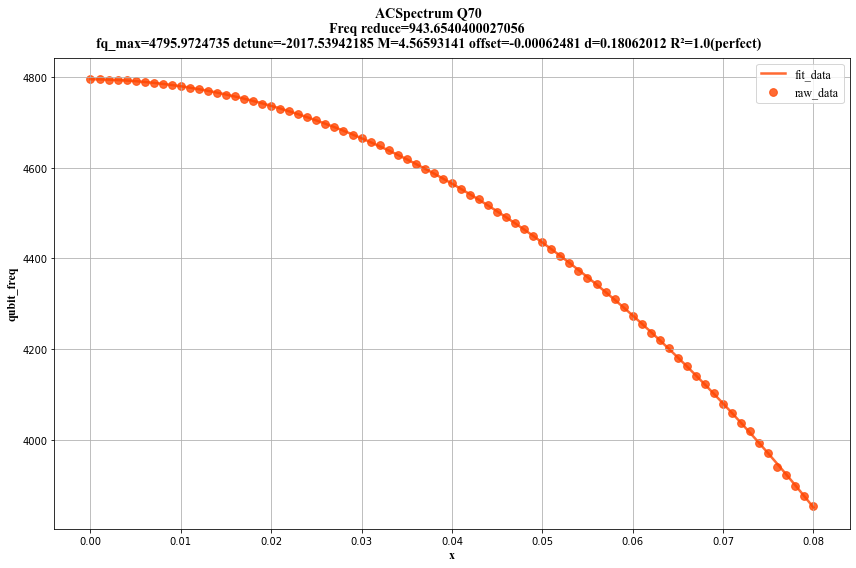

In [21]:
ACS_exp.analysis.drawer.figure

### 更新AC谱参数

In [60]:
from pyQCat.invoker import DataCenter
ACS_paras = ACS_exp.analysis.show_results()['value']
ACS_exp_quality = ACS_exp.analysis.quality.descriptor

if ACS_exp_quality == Quality.perfect:
    db = DataCenter()
    filename = 'character.json'
    data = db.query_config(filename)['data'][0]['json']
    data[q_name_list[0]]['frequency_zamp_fitting'] = ACS_paras  # z_delay
    db.update_single_config(filename, data)
    
    qubit.ac_spectrum.standard = ACS_paras
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-22 20:52:55 |  UPDATE  | Save q70 to data service success.


In [52]:
qubit.ac_spectrum.standard

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

## T1Spectrum

In [ ]:
T1S_exp = T1Spectrum.from_experiment_context(context)
T1S_exp.set_experiment_options(
    z_amp_list = qarange(-0.07, 0.07, 0.001),
    delay_list = qarange(0, 30000, 300),

#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)
T1S_exp.child_experiment.set_experiment_options(
    is_dynamic=False,)

T1S_exp.run()

### 查询实验结果

In [20]:
pd.DataFrame(T1S_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fq_max,4795.972473,None,{},R²=1.0(perfect)
1,detune,-2017.539422,None,{},R²=1.0(perfect)
2,M,4.565931,None,{},R²=1.0(perfect)
3,offset,-0.000625,None,{},R²=1.0(perfect)
4,d,0.180620,None,{},R²=1.0(perfect)


In [46]:
ACS_exp.analysis.show_results()['value']

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

### 查询实验结果图

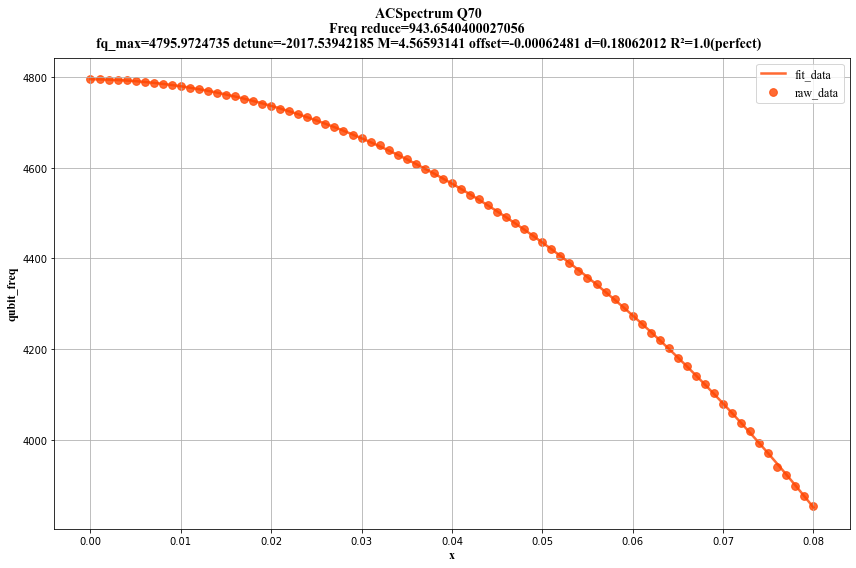

In [21]:
ACS_exp.analysis.drawer.figure

## ACSpectrum

In [ ]:
ACS_exp = ACSpectrum.from_experiment_context(context)
ACS_exp.set_experiment_options(
    z_amps=qarange(0, 0.08, 0.001),
    delays = qarange(80, 160, 2.5),
    init_fringe = 80,
    osc_freq_limit = 50,
    freq_bound = 4000,
#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)
ACS_exp.child_experiment.set_experiment_options(
    is_dynamic=False,
    repeat=700)

ACS_exp.run()

### 查询实验结果

In [20]:
pd.DataFrame(ACS_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fq_max,4795.972473,None,{},R²=1.0(perfect)
1,detune,-2017.539422,None,{},R²=1.0(perfect)
2,M,4.565931,None,{},R²=1.0(perfect)
3,offset,-0.000625,None,{},R²=1.0(perfect)
4,d,0.180620,None,{},R²=1.0(perfect)


In [46]:
ACS_exp.analysis.show_results()['value']

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

### 查询实验结果图

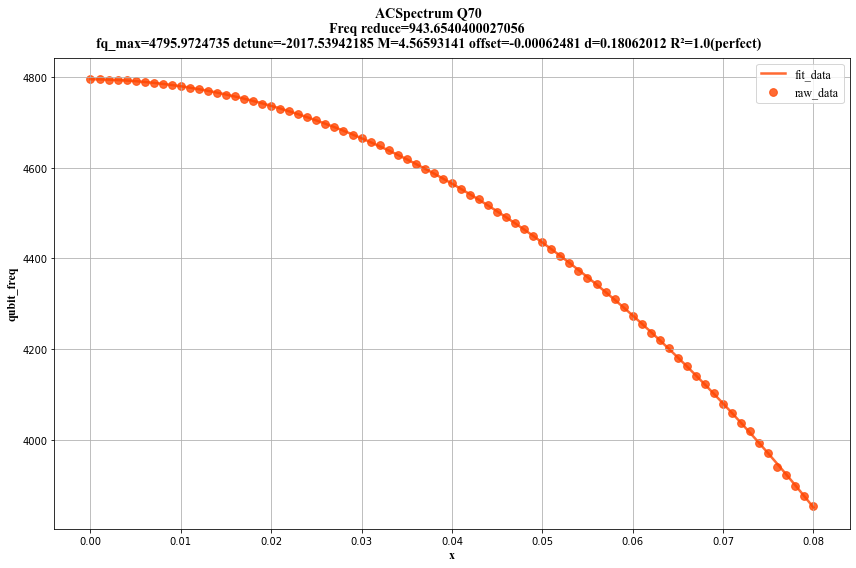

In [21]:
ACS_exp.analysis.drawer.figure

## XYZtiming

2022-12-10 22:12:39 |   EXP    | XYZTiming register success, id 639493d7da61ed419364bf69
2022-12-10 22:12:39 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\XYZTiming\q71\2022-12-10\22.12.07\


<IPython.core.display.Javascript object>


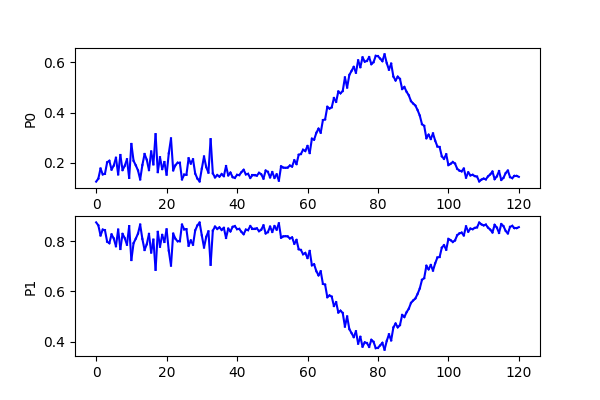

  0%|          | 0/193 [00:00<?, ?it/s]

2022-12-10 22:14:54 |  RESULT  | Experiment results as follow:
| name | describe | value | unit |      quality       | 
-------------------------------------------------------
|  fr  |  Delay   | 76.25 |  ns  | R²=0.9675(perfect) | 
2022-12-10 22:14:54 |   INFO   | Qubit(bit=71) XYZTiming, delay offset: -26.25
2022-12-10 22:14:54 |   INFO   | The XY line comes after the Z line，so add Z line delay 26.25


-26.25

In [49]:
xyz_exp = XYZTiming.from_experiment_context(context)
xyz_exp.set_experiment_options(
    ac_prepare_time=8000,
    delay_list = qarange(0, 120, 0.625),
    z_amp = 0.05,

#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)

xyz_exp.run()






### 查询脉冲时序图

In [ ]:
xyz_exp.jupyter_schedule()

### 查询实验结果

In [53]:
pd.DataFrame(xyz_exp.analysis.show_results())

,name,value,unit,extra,quality
0,Delay,85.0,ns,{},R²=0.9893(perfect)


### 查询实验结果图

In [ ]:
xyz_exp.analysis.drawer.figure

In [54]:
xyz_exp.analysis.results.fr.value

85.0

### 更新比特参数

In [52]:
from pyQCat.invoker import DataCenter

xyz_exp_quality = xyz_exp.analysis.quality.descriptor
Delay = 26.25
if xyz_exp_quality == Quality.perfect:
    db = DataCenter()
    filename = 'character.json'
    data = db.query_config(filename)['data'][0]['json']
    data[q_name]['hardware_offset'][1] = Delay  # z_delay
    db.update_single_config(filename, data)
else:
    pyqlog.info(f'Experiment results bad, please check!')

## DistortionT1

In [37]:
%matplotlib inline

In [11]:
Distortion_exp = DistortionT1Composite.from_experiment_context(context)
Distortion_exp.set_experiment_options(
    iteration_times = 2,
    xy_delay_max = 1000,
    init_step = 1.25,
    z_amp = -0.1,
    z_offset_list = qarange(-0.01, 0.015, 0.0002),

    simulator_data_path='E:\Data\D1\\20221107\\220826-72bit-300pin-V8.2-Base-24#_monster\DistortionT1Composite\q70\\2022-11-23\\00.44.11\DistortionT1/'
)

Distortion_exp.child_experiment.set_experiment_options(
    is_dynamic=0)


Distortion_exp.run()






ValueError: invalid literal for int() with base 10: 'iter0_xy_delay=1'